# Control Systems Engineering Final Project - Swing up and Balance of an Acrobot

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import (
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LeafSystem,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    wrap_to,
    RegionOfAttraction,
    LeafSystem,
    BasicVector,
    Parser,
    MultibodyPlant,
    VectorLogSink,
)
from pydrake.examples import AcrobotGeometry, AcrobotInput, AcrobotPlant, AcrobotState, AcrobotParams, AcrobotSpongController
from underactuated import running_as_notebook

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [ ]:
#Helper functions
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.0)
    state.set_theta1dot(0.0)
    state.set_theta2dot(0.0)
    return state

def wrap_to(theta, lower, upper):
    range_ = upper - lower
    return (theta - lower) % range_ + lower


In [ ]:
#Removing damping to replicate the parameters used in the Spong paper
acrobot = AcrobotPlant()
context = acrobot.CreateDefaultContext()
context.get_mutable_continuous_state_vector().SetFromVector(
        UprightState().CopyToVector()
    )
acrobot_params = acrobot.get_mutable_parameters(context)
acrobot_params.set_b1(0)
acrobot_params.set_b2(0)
print(acrobot.get_parameters(context))

[1.0, 1.0, 1.0, 2.0, 0.5, 1.0, 0.083, 0.33, 0.0, 0.0, 9.81]


## System Analysis
We can use drake to linearize the system and solve for K, S in an LQR. We can also analyse how controllable the system is. The SVD of the controllability matrix suggests that two of the states have very weak controllabilty. 

In [25]:

input = AcrobotInput()
input.set_tau(0.0)
acrobot.get_input_port(0).FixValue(context, input)

linearized_acrobot = Linearize(acrobot, context)

print("Linearized Acrobot A matrix:")
print(linearized_acrobot.A())
print("Linearized Acrobot B matrix:")
print(linearized_acrobot.B())

print("Controllability Matrix:")
controllability_matrix = ControllabilityMatrix(linearized_acrobot)
print(controllability_matrix)

print("SVD of Controllability Matrix:")
U, S, V = np.linalg.svd(controllability_matrix)
print("S:")
print(S)

Q = np.diag((1.0, 1.0, 1.0, 1.0))
R = [1]
K,S = LinearQuadraticRegulator(linearized_acrobot.A(), linearized_acrobot.B(), Q, R)
print("LQR Gain K:")
print(K)
print("LQR Solution S:")
print(S)

Linearized Acrobot A matrix:
[[  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]
 [ 12.62915809 -12.6926212    0.           0.        ]
 [-14.74882584  29.61188526   0.           0.        ]]
Linearized Acrobot B matrix:
[[ 0.        ]
 [ 0.        ]
 [-3.01465927]
 [ 6.03320007]]
Controllability Matrix:
[[   0.           -3.01465927    0.         -114.64973155]
 [   0.            6.03320007    0.          223.11711262]
 [  -3.01465927    0.         -114.64973155    0.        ]
 [   6.03320007    0.          223.11711262    0.        ]]
SVD of Controllability Matrix:
S:
[2.50940807e+02 2.50940807e+02 7.60446155e-02 7.60446155e-02]
LQR Gain K:
[[-246.71568974  -98.7840035  -106.51088742  -50.16020514]]
LQR Solution S:
[[12963.58487235  5822.76608577  5671.78456945  2793.17477104]
 [ 5822.76608577  2629.25143829  2549.43319199  1257.52309004]
 [ 5671.78456945  2549.43319199  2481.97933933  1222.53713508]
 [ 2793.17477104  1257.523

## The swing up and balance controller 
The controller is the combination of 3 control strategies - Energy shaping, Partial feedback linearization and LQR. More details about the implementation can be found in the report. What's cool is that drake can easily give us the Mass matrix and the dynamic bias terms directly which helps make the calculations very simple.

In [ ]:
class AcrobotController(LeafSystem):
    def __init__(self, k_e=2.5, k_p=16.0, k_d=8.0, balancing_threshold=1000, control_limit=20.0):
        super().__init__()
        self.DeclareVectorInputPort("acrobot_state", AcrobotState())
        self.DeclareVectorOutputPort("elbow_torque", AcrobotInput(), self.DoCalcControlTorque)

        self.x0 = np.array([np.pi, 0.0, 0.0, 0.0])

        self.acrobot = AcrobotPlant()
        self.acrobot_context = self.acrobot.CreateDefaultContext()
        self.acrobot_context.SetContinuousState(UprightState().CopyToVector())
        
        # These are the LQR gain and cost matrices we previously computed.
        self.K = np.array([[-246.71568974, -98.7840035, -106.51088742, -50.16020514]])
        self.S = np.array([
            [12963.58487235, 5822.76608577, 5671.78456945, 2793.17477104],
            [5822.76608577, 2629.25143829, 2549.43319199, 1257.52309004],
            [5671.78456945, 2549.43319199, 2481.97933933, 1222.53713508],
            [2793.17477104, 1257.52309004, 1222.53713508, 602.56127038]
        ])

        # Set controller parameters from initializer arguments.
        self.k_e = k_e
        self.k_p = k_p
        self.k_d = k_d
        self.balancing_threshold = balancing_threshold
        self.control_limit = control_limit

    def DoCalcControlTorque(self, context, output):
        x = self.get_input_port(0).Eval(context).copy()  
        x[0] = wrap_to(x[0], 0.0, 2 * np.pi)
        x[1] = wrap_to(x[1], -np.pi, np.pi)

        self.acrobot_context.get_mutable_continuous_state_vector().SetFromVector(x)

        # Calculate cost based on deviation from the target state.
        err = x - self.x0
        cost = err.T @ self.S @ err

        if cost < self.balancing_threshold:
            # Balancing mode (LQR control)
            u = self.K @ (self.x0 - x)
            u = u[0]  
        else:
            # Swing-up mode:
            p = self.acrobot.get_parameters(self.acrobot_context)
            M = self.acrobot.MassMatrix(self.acrobot_context)
            bias = self.acrobot.DynamicsBiasTerm(self.acrobot_context)
            M_inv = np.linalg.inv(M)

            # Compute current energy.
            PE = self.acrobot.EvalPotentialEnergy(self.acrobot_context)
            KE = self.acrobot.EvalKineticEnergy(self.acrobot_context)
            E = PE + KE

            # Desired energy level for the upright position.
            E_desired = (p.m1() * p.lc1() + p.m2() * (p.l1() + p.lc2())) * p.gravity()
            E_tilde = E - E_desired

            # Energy shaping control component.
            theta2dot = x[3]
            u_e = -self.k_e * E_tilde * theta2dot

            # Partial feedback linearization control component.
            theta1, theta2, theta1dot = x[0], x[1], x[2]
            y = -self.k_p * theta1 - self.k_d * theta1dot
            a2 = M_inv[0, 1]
            a3 = M_inv[1, 1]
            u_p = (a2 * bias[0] + y) / a3 + bias[1]

            # Total control torque.
            u = u_e + u_p

        # Clip the control input to the allowable limits.
        u = np.clip(u, -self.control_limit, self.control_limit)
        output.SetFromVector(np.array([u]))


## Simulation

Different parts of the controller can be run by changing the parameters when calling the controller.

### Controller Modes

- **LQR Only:**  
  Increase the balancing threshold to something very high like `1e8`.

- **Energy Shaping:**  
  Set the `k_p`, `k_d`, and the balancing threshold to zero.

- **Partial Feedback Linearization:**  
  Keep the balancing threshold at zero and use any nonzero values for the rest.

_All of the parameters can be changed to experiment with the controller._

### Output

The code outputs a plot showing the state evolution and the energy over time. The simulation can be seen in meshcat.


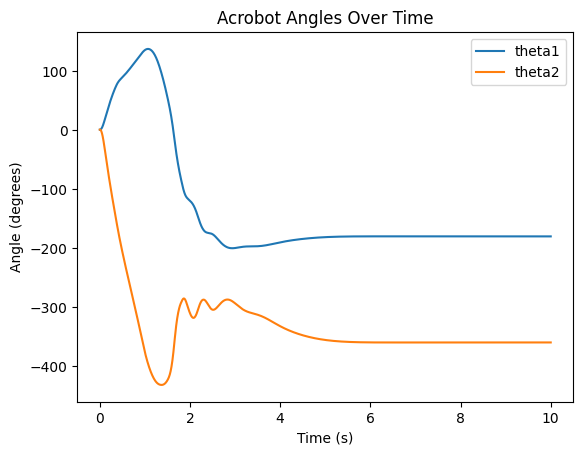

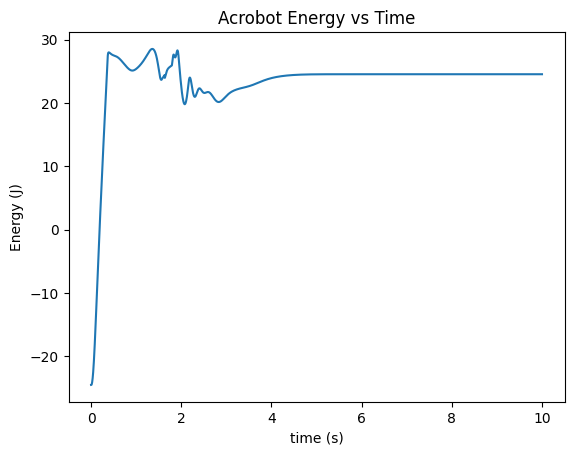

In [ ]:
def acrobot_balancing_example():
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-20], max_value=[20]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2.0 * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(AcrobotController(k_e=2.5, k_p=16.0, k_d=8.0, balancing_threshold=1000, control_limit=20.0)) 
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))

    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    logger = builder.AddSystem(VectorLogSink(4))  # 4 because the Acrobot output is 4D
    builder.Connect(acrobot.get_output_port(0), logger.get_input_port(0))

    # Setup visualization
    scene_graph = builder.AddSystem(SceneGraph())
    AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    
    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    duration = 10.0 if running_as_notebook else 0.1
    for i in range(1):
        context.SetTime(0.0)
        context.SetContinuousState(
            UprightState().CopyToVector()*0
            + 0.02*np.array([1,1,5,0]) #The starting configuration. Feel free to change this.
            
        )
        simulator.Initialize()
        simulator.AdvanceTo(duration)
    
    log = logger.FindLog(simulator.get_context())
    t = log.sample_times()
    state_samples = log.data()  

    plt.figure()
    plt.plot(t, state_samples[0, :]*180/np.pi, label="theta1")
    plt.plot(t, state_samples[1, :]*180/np.pi, label="theta2")
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title("Acrobot Angles Over Time")
    plt.legend()
    # plt.savefig("nonpfl_state.png")
    plt.show()

    energy_context = acrobot.CreateDefaultContext()
    energies = np.zeros(state_samples.shape[1])

    for i in range(state_samples.shape[1]):
        x = state_samples[:, i]
        energy_context.SetContinuousState(x)
        E_pot = acrobot.EvalPotentialEnergy(energy_context)
        E_kin = acrobot.EvalKineticEnergy(energy_context)
        energies[i] = E_pot + E_kin

    plt.figure()
    plt.plot(t, energies)
    plt.xlabel("time (s)")
    plt.ylabel("Energy (J)")
    plt.title("Acrobot Energy vs Time")
    # plt.savefig("nonpfl_energy.png")
    plt.show()




acrobot_balancing_example()

Below are codes we developed while experimenting and understanding the individual control strategies. These were all combined to write the primary controller shown above. 

In [6]:
def BalancingLQR():

    acrobot = AcrobotPlant()
    context = acrobot.CreateDefaultContext()

    input = AcrobotInput()
    input.set_tau(0.0)
    acrobot.get_input_port(0).FixValue(context, input)

    context.get_mutable_continuous_state_vector().SetFromVector(
        UprightState().CopyToVector()
    )

    Q = np.diag((10.0, 10.0, 1.0, 1.0))
    R = [1]

    return LinearQuadraticRegulator(acrobot, context, Q, R)

In [7]:
class AcrobotLQR(LeafSystem):
    def __init__(self, acrobot):
        super().__init__()
        self.DeclareVectorInputPort("state", 4)
        self.DeclareVectorOutputPort("control", 1, self.DoCalcOutput)

        self.acrobot = acrobot
        self.acrobot_context = acrobot.CreateDefaultContext()

        # Set the plant parameters if needed
        self.SetAcrobotParams(acrobot_params)

        # Set the acrobot's state to the "upright" for linearization
        x_eq = UprightState()
        self.acrobot_context.SetContinuousState(x_eq.CopyToVector())

        # Fix the nominal torque to zero at the equilibrium
        nominal_input = AcrobotInput()
        nominal_input.set_tau(0.0)
        self.acrobot.get_input_port(0).FixValue(self.acrobot_context, nominal_input)

        # Linearize about [theta1=pi, theta2=0, thetadots=0] and tau=0
        linearized = Linearize(self.acrobot, self.acrobot_context)
        A = linearized.A()
        B = linearized.B()

        Q = np.diag([1., 1., 1., 1.])
        R = [1.]

        self.K, _ = LinearQuadraticRegulator(A, B, Q, R)

        # Store the equilibrium state in a numpy array for convenience
        self.x_eq = x_eq.CopyToVector()

    def SetAcrobotParams(self, params):
        self.acrobot_context.get_mutable_numeric_parameter(0).SetFromVector(
            params.CopyToVector()
        )

    def DoCalcOutput(self, context, output):
        # Current full state from the port
        x = self.get_input_port(0).Eval(context)


        delta_x = x - self.x_eq

        u = -self.K @ delta_x

        output.SetAtIndex(0, u)


In [8]:
class AcrobotEnergyShapingController(LeafSystem):
    def __init__(self, acrobot):
        super().__init__()
        self.DeclareVectorInputPort("state", 4)
        self.DeclareVectorOutputPort("control", 1, self.DoCalcOutput)
        self.acrobot = acrobot
        self.acrobot_context = acrobot.CreateDefaultContext()
        self.SetAcrobotParams(AcrobotParams())

    def SetAcrobotParams(self, params):
        self.acrobot_context.get_mutable_numeric_parameter(0).SetFromVector(
            params.CopyToVector()
        )
        self.acrobot_context.SetContinuousState(UprightState().CopyToVector())
        self.desired_energy = (self.acrobot.EvalPotentialEnergy(self.acrobot_context) +
                               self.acrobot.EvalKineticEnergy(self.acrobot_context))

    def DoCalcOutput(self, context, output):
        acrobot_state = self.get_input_port(0).Eval(context)
        self.acrobot_context.SetContinuousState(acrobot_state)
        params = self.acrobot_context.get_numeric_parameter(0)
        
        theta2dot = acrobot_state[3]
        
        total_energy = (self.acrobot.EvalPotentialEnergy(self.acrobot_context) +
                        self.acrobot.EvalKineticEnergy(self.acrobot_context))
        energy_error = total_energy - self.desired_energy
        
        u =  - 0.1 * theta2dot * energy_error
        u = np.clip(u, -7, 7)
        output.SetAtIndex(0, u)

In [9]:
class SwingUpAndBalanceAcrobotController(LeafSystem):
    def __init__(self, acrobot):
        super().__init__()
        
        # Input port for [theta1, theta2, theta1dot, theta2dot].
        self.DeclareVectorInputPort("state", 4)

        # Output port for the control torque.
        self.DeclareVectorOutputPort("control", 1, self.DoCalcOutput)

        # Example LQR gain. Suppose your linearization gave you a positive K:
        self.K = np.array([[246.7, 98.8, 106.5, 50.16]])  # shape (1, 4)

        # Create (or attach) your energy-shaping controller.
        self.energy_shaping = AcrobotEnergyShapingController(acrobot)
        self.energy_shaping_context = self.energy_shaping.CreateDefaultContext()

        # For convenience, pin a fixed input vector for the sub-controller.
        self.energy_input_port = (
            self.energy_shaping.get_input_port(0).FixValue(
                self.energy_shaping_context, np.zeros(4)
            )
        )

        # Threshold for switching to LQR mode.
        self.switch_threshold = 1e3

        # Torque saturation limit:
        self.torque_limit = 20.0

    def DoCalcOutput(self, context, output):
        x = self.get_input_port(0).Eval(context)

        # Wrap angles so that the *first* angle is near zero when theta1 = pi,
        # i.e., xbar[0] = (theta1 - pi). We wrap to [-pi, pi] so we do not
        # accumulate multiples of 2*pi.
        xbar = np.copy(x)
        xbar[0] = wrap_to(x[0], -np.pi, np.pi) - np.pi
        xbar[1] = wrap_to(x[1], -np.pi, np.pi)
        # Keep the velocities as-is: xbar[2], xbar[3].

        # Example switch: norm-squared of xbar
        cost = xbar.dot(xbar)
        if cost < self.switch_threshold:
            # LQR about upright.  Note the sign convention: we do u = -K*xbar
            # because xbar is (x - x0) but effectively 0 at the upright.
            u_lqr = - self.K.dot(xbar)
            u = u_lqr.item()
            output.SetFromVector([u_lqr])
        else:
            # Use energy-shaping to swing up.
            # Feed x to the energy_shaping sub-system by updating the input port's value.
            self.energy_input_port.SetFromVector(x)
            u_energy = self.energy_shaping.get_output_port(0).Eval(self.energy_shaping_context)
            output.SetFromVector(u_energy)

        
